<a href="https://colab.research.google.com/github/Lahari-Dongari/Wildlife_yolo_Detector/blob/main/wildanimal_by_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install roboflow ultralytics supervision

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
from ultralytics import YOLO
import supervision as sv
import requests
import numpy as np
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = '/content/drive/MyDrive/yolo_dataset/WILD ANIMALS DETECTION.v1i.yolov8.zip'
extract_path = '/content/drive/MyDrive/yolo_dataset/wild_animals_extracted/'

In [ ]:
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os
print(os.listdir(extract_path))

['README.dataset.txt', 'README.roboflow.txt', 'data.yaml', 'test', 'train', 'valid']


In [ ]:
!apt-get install -y tree
!tree -L 2 "{extract_path}"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/content/drive/MyDrive/yolo_dataset/wild_animals_extracted/
├── data.yaml
├── README.dataset.txt
├── README.roboflow.txt
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   ├── labels
│   └── labels.cache
└── valid
    ├── images
    ├── labels
    └── labels.cache

9 directories, 5 files


In [ ]:
model = YOLO('yolov8n.pt')

model.train(
    data="/content/drive/MyDrive/yolo_dataset/wild_animals_extracted/data.yaml",
    epochs=50,
    imgsz=640,
    batch=8
)


Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/yolo_dataset/wild_animals_extracted/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patienc

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b5f238d4dd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [ ]:


def display_prediction(image_path, save_fig=False, filename=None):
    """
    Function to display predictions of a trained YOLO model on a given image.
    """

    # Load YOLO model (your trained weights)
    model = YOLO("/content/runs/detect/train4/weights/best.pt")

    class_dict = model.names

    # Load image (from URL or local path)
    if image_path.startswith(('http', 'https')):
        try:
            response = requests.get(image_path)
            image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
            img = cv.imdecode(image_array, cv.IMREAD_COLOR)
        except Exception as e:
            print(f"Error loading image from URL: {e}")
            return
    else:
        img = cv.imread(image_path)

    if img is None:
        print("Couldn't load the image! Please check the image path.")
        return

    # Get dimensions
    h, w = img.shape[:2]
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=(w, h))
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=(w, h))

    # Colors and annotators
    color_palette = sv.ColorPalette.from_matplotlib('magma', 10)
    box_annotator = sv.BoxAnnotator(thickness=thickness, color=color_palette)
    label_annotator = sv.LabelAnnotator(color=color_palette, text_scale=text_scale,
                                        text_thickness=thickness, text_position=sv.Position.TOP_LEFT)

    # Run model
    result = model(img)[0]
    detections = sv.Detections.from_ultralytics(result)

    if detections.class_id is not None:
        detections = detections[(detections.confidence > 0.5)]
        labels = [f"{class_dict[cls_id]} {conf*100:.2f}%" for cls_id, conf in
                  zip(detections.class_id, detections.confidence)]
        box_annotator.annotate(img, detections=detections)
        label_annotator.annotate(img, detections=detections, labels=labels)

    # Show annotated image
    fig = plt.figure(figsize=(12, 10))
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')

    if save_fig and filename:
        save_dir = "DATA/IMAGES/detected_images"
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, filename)
        fig.savefig(save_path, bbox_inches='tight', dpi=200)
        print(f"Image saved successfully at {save_path}")

    plt.show()



0: 640x640 1 Zebra, 220.2ms
Speed: 4.3ms preprocess, 220.2ms inference, 12.4ms postprocess per image at shape (1, 3, 640, 640)
Image saved successfully at DATA/IMAGES/detected_images/predicted.jpg


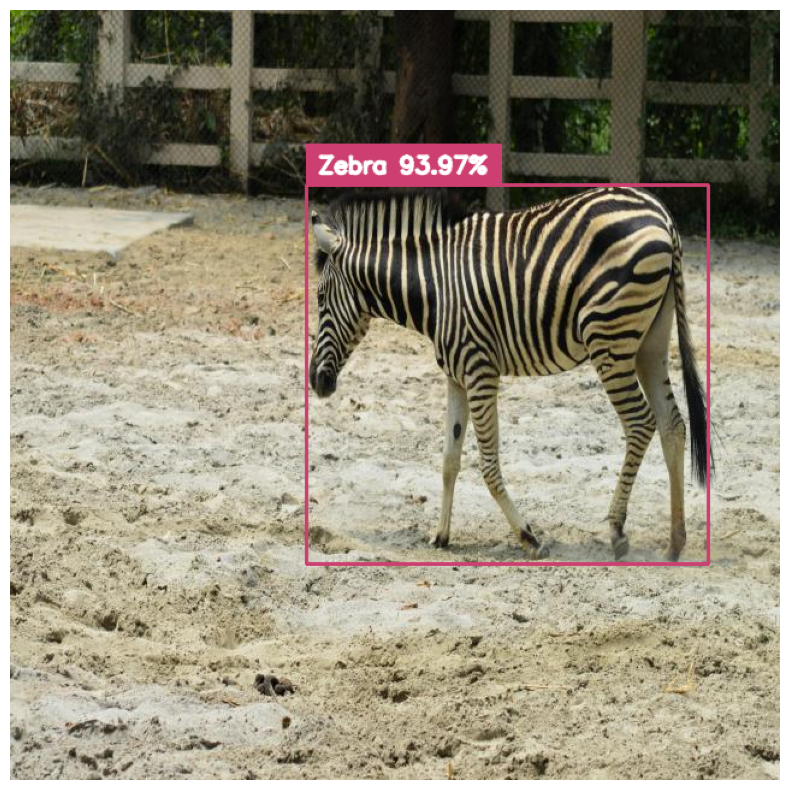

In [ ]:


# Path to one of your test images
test_image = "/content/drive/MyDrive/yolo_dataset/wild_animals_extracted/test/images/pexels-arifur18-997261_jpg.rf.2b5b72cf4404c40ec5af84d958a58fc3.jpg"

display_prediction(test_image, save_fig=True, filename="predicted.jpg")




0: 448x640 1 Elephant, 5 Giraffes, 1 Zebra, 222.3ms
Speed: 6.5ms preprocess, 222.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Image saved successfully at DATA/IMAGES/detected_images/predicted.jpg


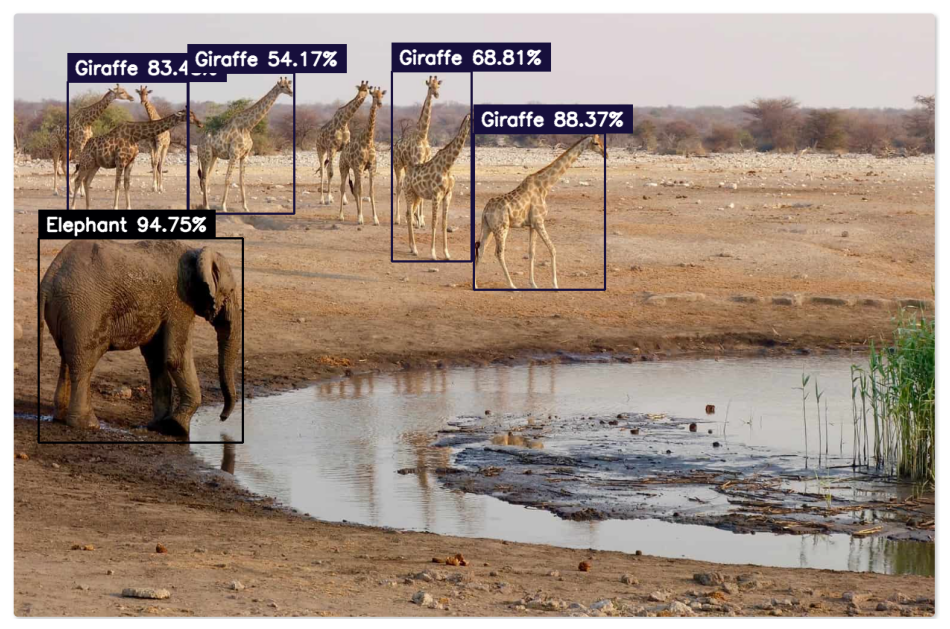

In [ ]:
# Path to one of your test images
test_image = "/content/drive/MyDrive/elephant.png"

display_prediction(test_image, save_fig=True, filename="predicted.jpg")


0: 384x640 1 Elephant, 2 Giraffes, 154.1ms
Speed: 6.3ms preprocess, 154.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Image saved successfully at DATA/IMAGES/detected_images/predicted.jpg


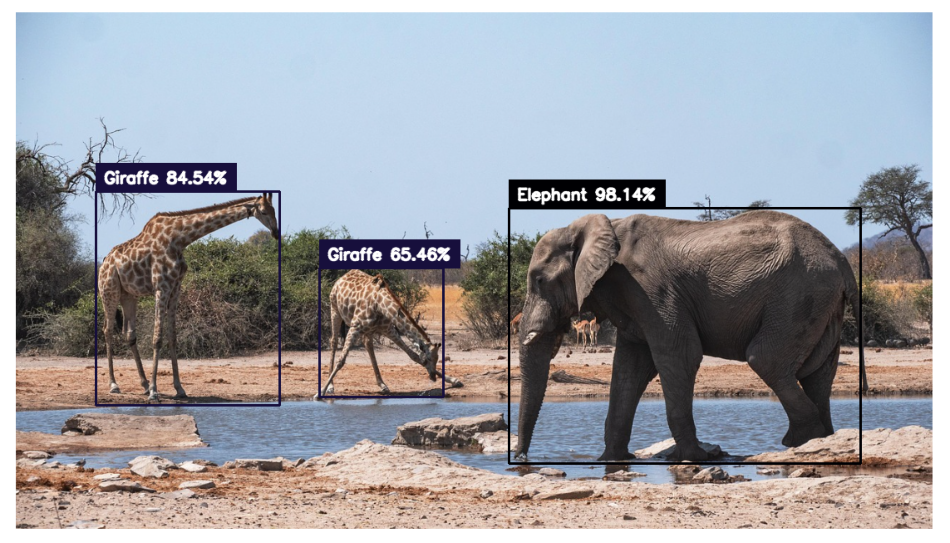

In [ ]:
# Path to one of your test images
test_image = "/content/drive/MyDrive/giraffee.png"

display_prediction(test_image, save_fig=True, filename="predicted.jpg")

In [ ]:

import supervision as sv


def predict_in_videos(video_path, save_video=True, filename="output.avi"):
    """
    Make predictions on a video using YOLOv8 and save annotated output.
    Works properly in Google Colab.
    """
    try:
        # Get video info
        video_info = sv.VideoInfo.from_video_path(video_path=video_path)
        w, h, fps = int(video_info.width), int(video_info.height), int(video_info.fps)

        # Annotation settings
        thickness = sv.calculate_optimal_line_thickness(resolution_wh=video_info.resolution_wh)
        text_scale = sv.calculate_optimal_text_scale(resolution_wh=video_info.resolution_wh)

        # Load YOLO model (update path if needed)
        model = YOLO("/content/runs/detect/train4/weights/best.pt")
        tracker = sv.ByteTrack(frame_rate=fps)
        class_dict = model.names

        # Setup video writer
        save_dir = "DATA/VIDEOS/captured_videos"
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, filename)
        out = cv.VideoWriter(save_path, cv.VideoWriter_fourcc(*"XVID"), fps, (w, h))

        # Read video
        cap = cv.VideoCapture(video_path)
        if not cap.isOpened():
            raise Exception("Error: couldn't open the video!")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # YOLO inference
            result = model(frame)[0]
            detections = sv.Detections.from_ultralytics(result)
            detections = tracker.update_with_detections(detections)

            if detections.tracker_id is not None:
                detections = detections[detections.confidence > 0.5]
                labels = [f"{class_dict[cls_id]} {conf*100:.1f}%"
                          for cls_id, conf in zip(detections.class_id, detections.confidence)]

                # Annotators
                box_annotator = sv.BoxAnnotator(thickness=thickness, color_lookup=sv.ColorLookup.TRACK)
                label_annotator = sv.LabelAnnotator(text_scale=text_scale, text_thickness=thickness,
                                                    text_position=sv.Position.TOP_LEFT,
                                                    color_lookup=sv.ColorLookup.TRACK)

                box_annotator.annotate(frame, detections=detections)
                label_annotator.annotate(frame, detections=detections, labels=labels)

            out.write(frame)

    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        cap.release()
        out.release()
        print(f" Video saved at: {save_path}")


In [ ]:
video_path = "/content/drive/MyDrive/video.mp4"
predict_in_videos(video_path, save_video=True, filename="output.avi")



0: 352x640 1 Elephant, 2 Giraffes, 6 Zebras, 137.4ms
Speed: 2.9ms preprocess, 137.4ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 Elephant, 4 Giraffes, 7 Zebras, 111.8ms
Speed: 3.0ms preprocess, 111.8ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 Elephant, 2 Giraffes, 7 Zebras, 109.9ms
Speed: 3.0ms preprocess, 109.9ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 Elephant, 2 Giraffes, 6 Zebras, 106.6ms
Speed: 2.3ms preprocess, 106.6ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 Elephant, 2 Giraffes, 4 Zebras, 106.4ms
Speed: 3.8ms preprocess, 106.4ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 Elephant, 3 Giraffes, 5 Zebras, 167.5ms
Speed: 3.0ms preprocess, 167.5ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 Elephant, 3 Giraffes, 6 Zebras, 168.6ms
Speed: 3.1ms preprocess, 168.6ms i